# Laboratory practice № 9 (Linear Matrix Inequalities)

Done by Vladislav Diuzhev (isu: 336225, group: R33353)

Variant: 8

## Preparation

In [1]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp

## Task 1

In [2]:
A = np.array([
    [-1, 0, 0, 0],
    [0, 2, 0, 0],
    [0, 0, 3, 4],
    [0, 0, -4, 3]
])

B = np.array([
    [0],
    [5],
    [0],
    [6]
])

In [3]:
np.linalg.eigvals(A)

array([ 3.+4.j,  3.-4.j, -1.+0.j,  2.+0.j])

In [4]:
alphas_1 = [0.1, 0.3, 0.7, 1]

In [5]:
def get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value) 

def get_K_LMI_mu(a, b, alpha, x0, mu=None):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    if mu is None:
        mu_ = cp.Variable((1,1))
    else:
        mu_ = mu
    sub1 = cp.bmat([
        [P, x0],
        [x0.T, [[1]]]
    ])
    if mu is None:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, mu_]
        ])
    else:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, [[mu_*mu_]]]
        ])
    prob = cp.Problem(cp.Maximize(0) if mu is not None else cp.Minimize(mu_),
                      [P >> np.eye(4), 
                       P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0,
                       sub1 >> 0, sub2 >> 0])
    res = prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value), np.sqrt(res.value)

In [6]:
Ks_1 = [get_K_LMI(A,B,alph) for alph in alphas_1]
Ks_1

[array([[ 0.        , -1.63367203, -2.79628983, -0.22685881]]),
 array([[ 0.        , -1.95653385, -3.22275083, -0.07284186]]),
 array([[ 0.        , -2.57597215, -3.99200995,  0.25760745]]),
 array([[ 0.        , -3.15751737, -4.66737381,  0.59616596]])]

In [7]:
eig = [np.round(np.linalg.eigvals(A + B@K),3) for K in Ks_1]
eig

[array([-0.47+6.893j, -0.47-6.893j, -0.59+0.j   , -1.  +0.j   ]),
 array([-0.704+7.199j, -0.704-7.199j, -0.812+0.j   , -1.   +0.j   ]),
 array([-1.082+7.717j, -1.082-7.717j, -1.171+0.j   , -1.   +0.j   ]),
 array([-1.378+8.141j, -1.378-8.141j, -1.455+0.j   , -1.   +0.j   ])]

In [8]:
systems_1 = [ctrl.ss(A + B@K,np.zeros((4,1)),np.zeros((1,4)),0) for K in Ks_1]
time_1 = np.linspace(0,10,int(10/0.001))
ys_1 = [ctrl.initial_response(sys,time_1,X0=np.ones((4,1))) for sys in systems_1]

States

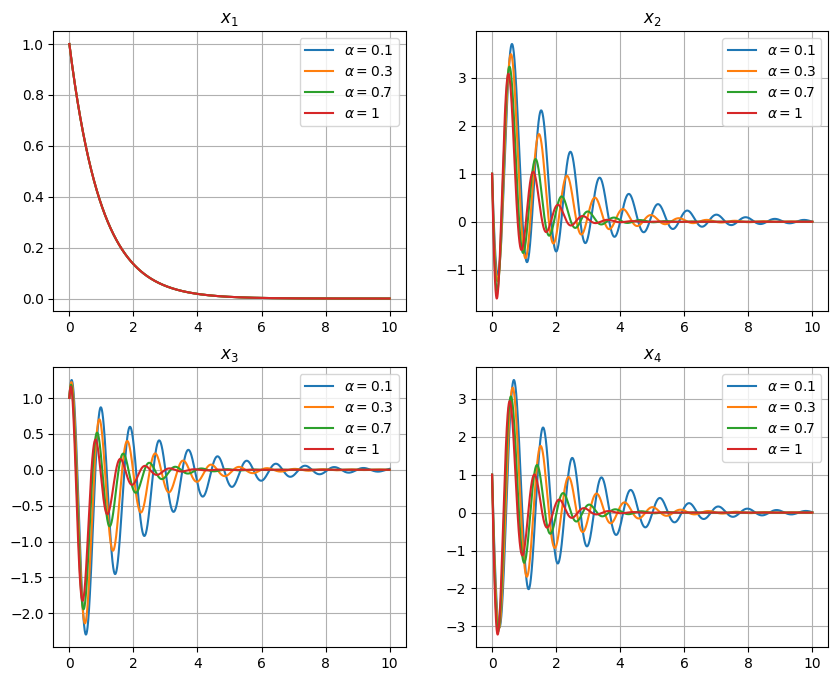

In [9]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_1)):
            ax[i,j].plot(time_1,ys_1[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_1[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

Input signal

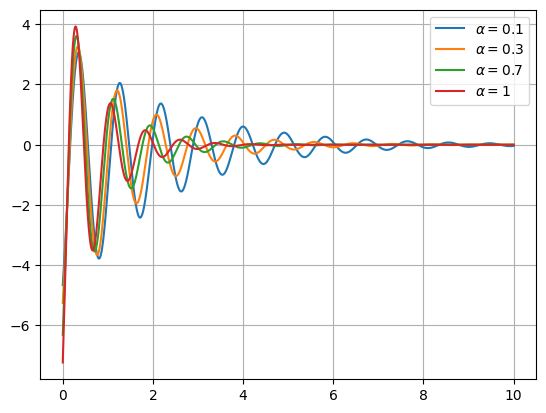

In [10]:
for y_i in range(len(ys_1)):
    plt.plot(time_1,(Ks_1[y_i]@ys_1[y_i].states).reshape(-1),label=f"$\\alpha={alphas_1[y_i]}$")
plt.grid(True)
plt.legend()

## Task 2

In [11]:
X_0 = np.array([
    [1],
    [1],
    [1],
    [1]
])

Minimizing

In [12]:
Ks_mus_2 = [get_K_LMI_mu(A,B,alpha,X_0) for alpha in alphas_1]
Ks_mus_2

[(array([[ 0.00332631, -0.86454435, -1.64131088, -0.66327284]]),
  4.240468209294919),
 (array([[ 1.40334187e-03, -1.03046990e+00, -1.90408191e+00,
          -6.24438943e-01]]),
  4.7930471740424245),
 (array([[ 0.00298614, -1.43052431, -2.49260666, -0.49219821]]),
  6.022756395321168),
 (array([[ 4.15200228e-07, -1.78970150e+00, -2.98569251e+00,
          -3.41918112e-01]]),
  7.056990709388924)]

In [13]:
get_K_LMI_mu(A,B,1,X_0,6.8)

/home/vladislav/.pyenv/versions/3.10.11/envs/control/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(array([[ 8.65642167e-07, -1.61012121e+00, -2.73340209e+00,
         -4.90542513e-01]]),
 0.0)

In [14]:
eig = [np.round(np.linalg.eigvals(A + B@K_mu[0]),3) for K_mu in Ks_mus_2]
eig

[array([-0.099+5.525j, -0.099-5.525j, -0.104+0.j   , -1.   +0.j   ]),
 array([-0.299+5.725j, -0.299-5.725j, -0.301+0.j   , -1.   +0.j   ]),
 array([-0.701+6.137j, -0.701-6.137j, -0.705+0.j   , -1.   +0.j   ]),
 array([-1.+6.458j, -1.-6.458j, -1.+0.j   , -1.+0.j   ])]

In [15]:
systems_2 = [ctrl.ss(A + B@K_mu[0],np.zeros((4,1)),np.zeros((1,4)),0) for K_mu in Ks_mus_2]
time_2 = np.linspace(0,10,int(10/0.001))
ys_2 = [ctrl.initial_response(sys,time_2,X0=np.ones((4,1))) for sys in systems_2]

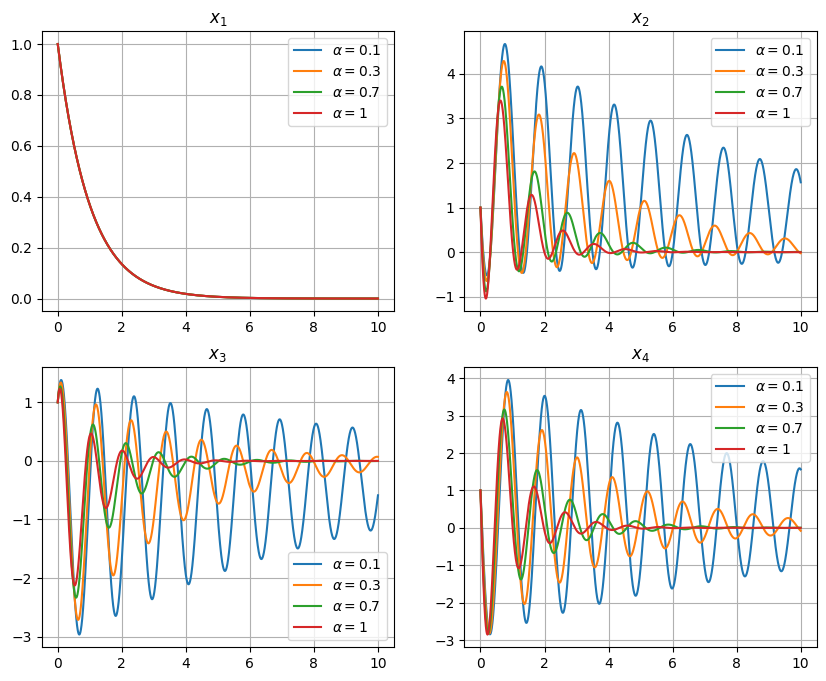

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_2)):
            ax[i,j].plot(time_1,ys_2[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_1[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

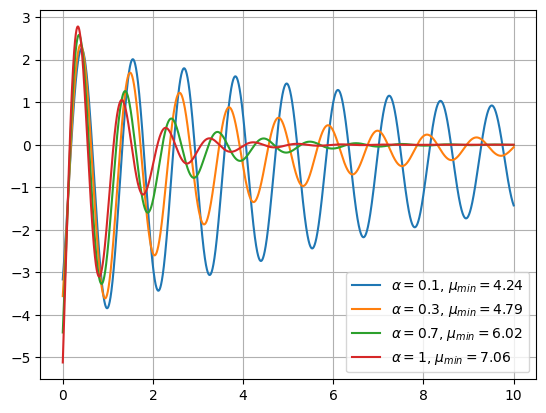

In [17]:
for y_i in range(len(ys_2)):
    plt.plot(time_2,(Ks_mus_2[y_i][0]@ys_2[y_i].states).reshape(-1),label=f"$\\alpha={alphas_1[y_i]}$, $\\mu_{'{min}'}={round(Ks_mus_2[y_i][1],2)}$")
plt.grid(True)
plt.legend()

Bound the input signal

In [18]:
mus_2 = [9, 8, 7, 6]
Ks_2 = [get_K_LMI_mu(A,B,0.7,X_0,mus_2[mu_i])[0] for mu_i in range(len(mus_2))]
Ks_2

[array([[ 6.03770804e-04, -1.52013522e+00, -2.61915238e+00,
         -5.82322432e-01]]),
 array([[ 1.00768876e-19, -1.34403105e+00, -2.37090945e+00,
         -7.03203512e-01]]),
 array([[ 6.21127123e-04, -1.48487551e+00, -2.55587005e+00,
         -5.44134280e-01]]),
 array([[ 1.65030585e-04, -1.34286279e+00, -2.35501912e+00,
         -5.96572020e-01]])]

In [19]:
eig = [np.round(np.linalg.eigvals(A + B@K),3) for K in Ks_2]
eig

[array([-1.039+5.796j, -1.039-5.796j, -1.017+0.j   , -1.   +0.j   ]),
 array([-0.987+5.441j, -0.987-5.441j, -0.965+0.j   , -1.   +0.j   ]),
 array([-0.891+5.921j, -0.891-5.921j, -0.907+0.j   , -1.   +0.j   ]),
 array([-0.762+5.795j, -0.762-5.795j, -0.77 +0.j   , -1.   +0.j   ])]

In [20]:
systems_2_ = [ctrl.ss(A + B@K,np.zeros((4,1)),np.zeros((1,4)),0) for K in Ks_2]
time_2_ = np.linspace(0,10,int(10/0.001))
ys_2_ = [ctrl.initial_response(sys,time_2_,X0=np.ones((4,1))) for sys in systems_2_]

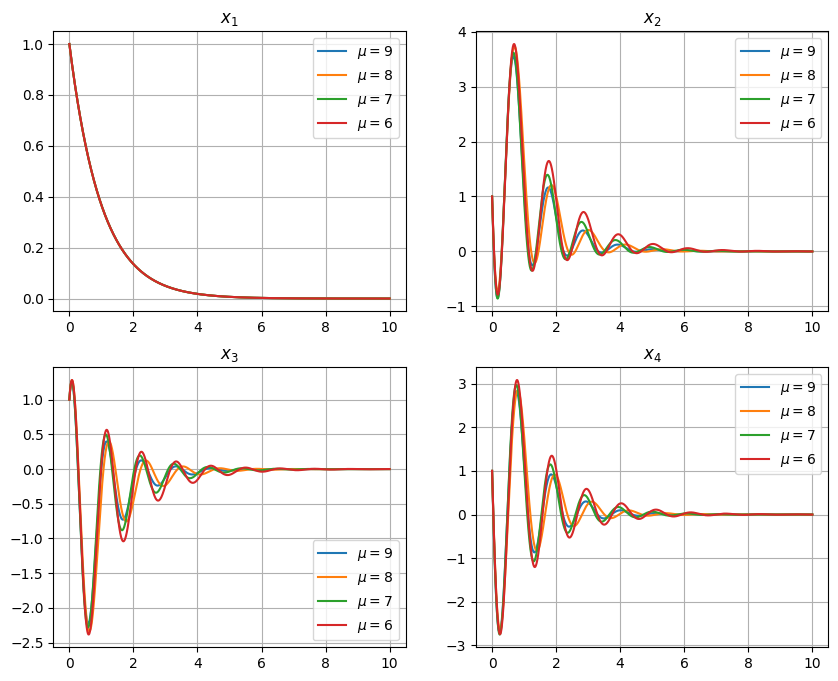

In [21]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_2_)):
            ax[i,j].plot(time_2_,ys_2_[y_i].states[i*2 + j,:],label=f"$\\mu={mus_2[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

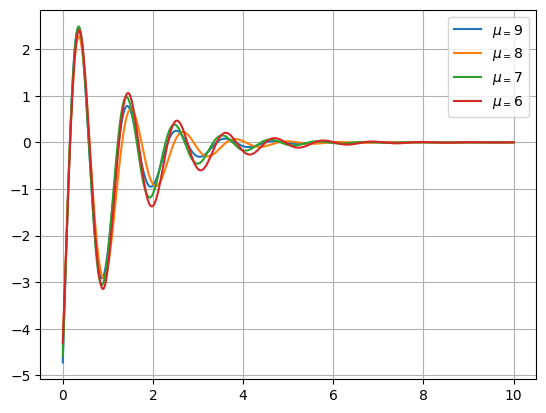

In [22]:
for y_i in range(len(ys_2_)):
    plt.plot(time_2_,(Ks_2[y_i]@ys_2_[y_i].states).reshape(-1),label=f"$\\mu_={round(mus_2[y_i],2)}$")
plt.grid(True)
plt.legend()

## Task 3

In [23]:
A = np.array([
    [0, 3, 0 ,0],
    [-3, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, -1, 0]
])
C = np.array([2, 0, 0, 3]).reshape((1,-1))

In [24]:
def get_L_LMI(a, c, alpha):
    Q = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((c.shape[1],c.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[Q >> np.eye(4), 
                                      a.T@Q + Q@A + 2*alpha*Q + c.T@Y.T + Y@c << 0])
    prob.solve()
    # print(Q.value, Y.value)
    return np.linalg.inv(Q.value) @ Y.value


In [25]:
alphas_2 = [1, 3, 6, 9]

In [31]:
Ls = [get_L_LMI(A,C,alpha) for  alpha in alphas_2]

for l in Ls:
    print("{} & {} & {} & {}".format(*np.round(l.reshape(-1),2)))

1.31 & -2.69 & 2.17 & -2.72
43.51 & 1.9 & 58.26 & -34.21
430.24 & 412.21 & 1064.31 & -297.3
1404.68 & 2235.75 & 4998.16 & -952.19


In [33]:
eig = [np.round(np.linalg.eigvals(A + L@C),3) for L in Ls]
for l in eig:
    print("{}, {}, {}, {}".format(*np.round(l.reshape(-1),2)))

(-1.33+4.39j), (-1.33-4.39j), (-1.43+1.39j), (-1.43-1.39j)
(-4.17+8.89j), (-4.17-8.89j), (-3.63+1.76j), (-3.63-1.76j)
(-8.48+18.71j), (-8.48-18.71j), (-7.24+3.13j), (-7.24-3.13j)
(-12.83+27.16j), (-12.83-27.16j), (-10.78+4.32j), (-10.78-4.32j)


In [166]:
system_3 = ctrl.ss(A, [[0]]*4,C,0)
systems_3_obs = [ctrl.ss(A + L@C,-L,C,0) for L in Ls]
time_3 = np.linspace(0,5,int(5/0.001))
y_3 = ctrl.initial_response(system_3,time_3,X0=np.ones((4,1)))
ys_3_obs = [ctrl.forced_response(sys_obs,time_3,X0=np.array([[2],[0],[0],[-1]]),U=y_3.outputs) for sys_obs in systems_3_obs]

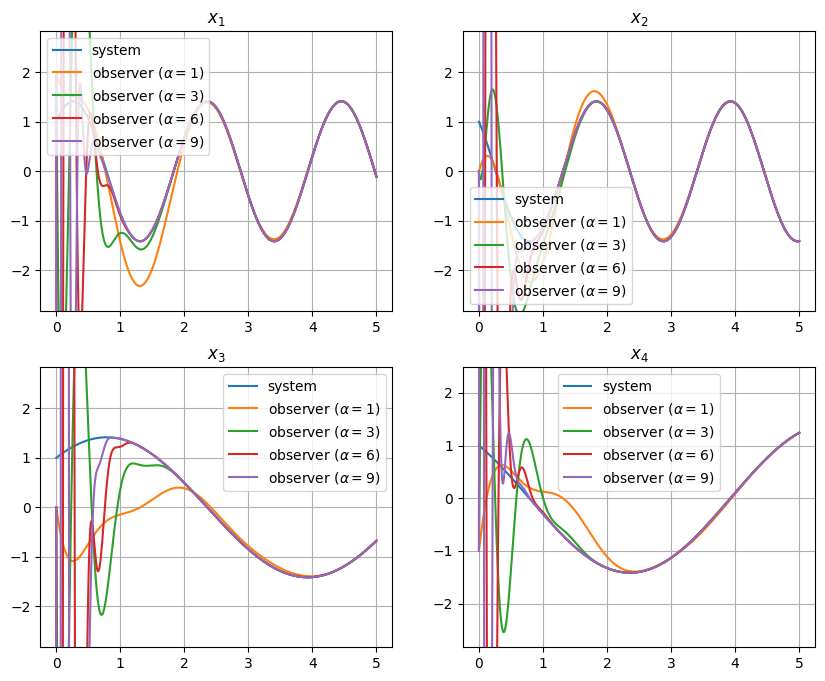

In [167]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        ax[i,j].plot(time_3,y_3.states[i*2 + j,:],label=f"system")
        ax[i,j].set_ylim([2*np.min(y_3.states[i*2 + j,:]),2*np.max(y_3.states[i*2 + j,:])])
        for y_i in range(len(ys_3_obs)):
            ax[i,j].plot(time_3,ys_3_obs[y_i].states[i*2 + j,:],label=f"observer ($\\alpha={alphas_2[y_i]}$)")
        ax[i,j].grid(True)
        ax[i,j].legend()

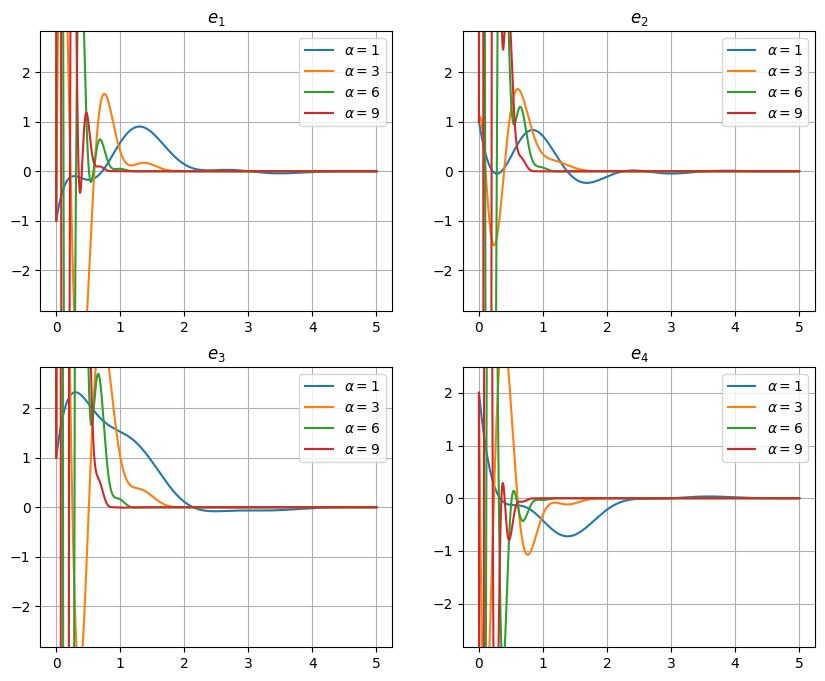

In [168]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$e_{i*2 + j+1}$")
        ax[i,j].set_ylim([2*np.min(y_3.states[i*2 + j,:]),2*np.max(y_3.states[i*2 + j,:])])
        for y_i in range(len(ys_3_obs)):
            ax[i,j].plot(time_3,y_3.states[i*2 + j,:] - ys_3_obs[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_2[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

## Task 4

In [169]:
A = np.array([
    [3, -11, -7, 5],
    [-11, 3, -5, 7],
    [-7, -5, 3, 11],
    [5, 7, 11, 3]
])
B = np.array([
    [2],
    [4],
    [2],
    [4]
])
C = np.array([
    [2, -2, 2, 2],
    [2, 4, -2, 4]
])

In [170]:
alpha_sys = 2
alphas_obs = [0.5, 2, 4]

In [171]:
K = get_K_LMI(A, B, 2)
Ls = [get_L_LMI(A, C, alpha) for alpha in alphas_obs]

In [172]:
As_new = [np.block([
    [A + B@K, -B@K],
    [np.zeros_like(A), A + L@C]
]) for L in Ls]

In [173]:
systems_4 = [ctrl.ss(A_new,np.zeros((8,1)),np.zeros((1,8)),0) for A_new in As_new]
time_4 = np.linspace(0,3,int(3/0.001))
ys_4 = [ctrl.initial_response(sys,T=time_4,X0=[-1,-1,-1,-1,2,2,2,2]) for sys in systems_4]

obs < cont

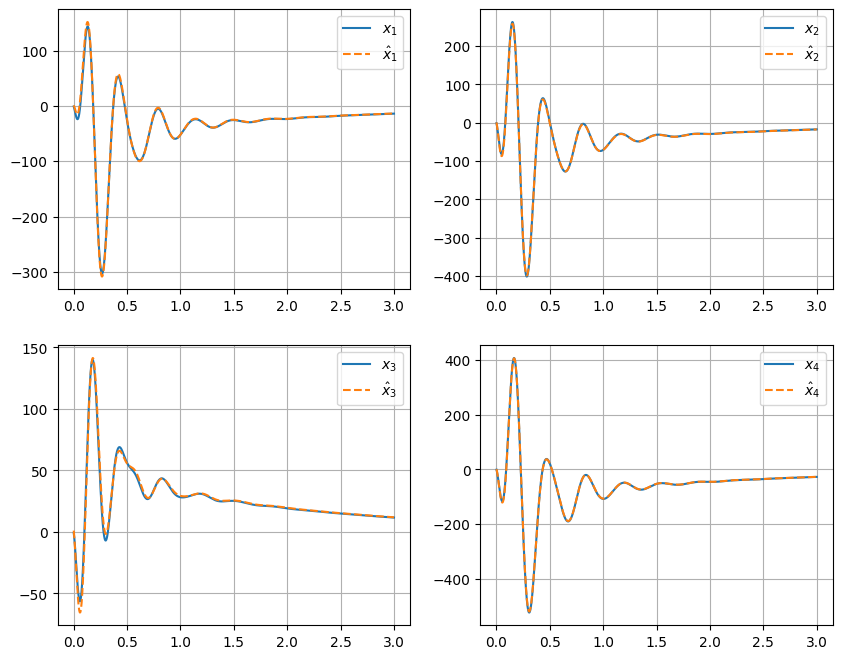

In [174]:
y = ys_4[0]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid()
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid()
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid()
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid()

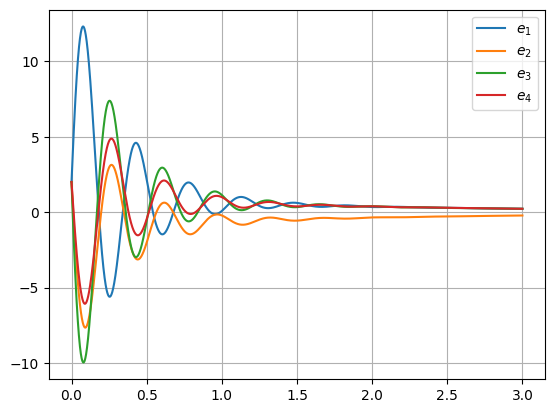

In [175]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.grid()

obs = cont

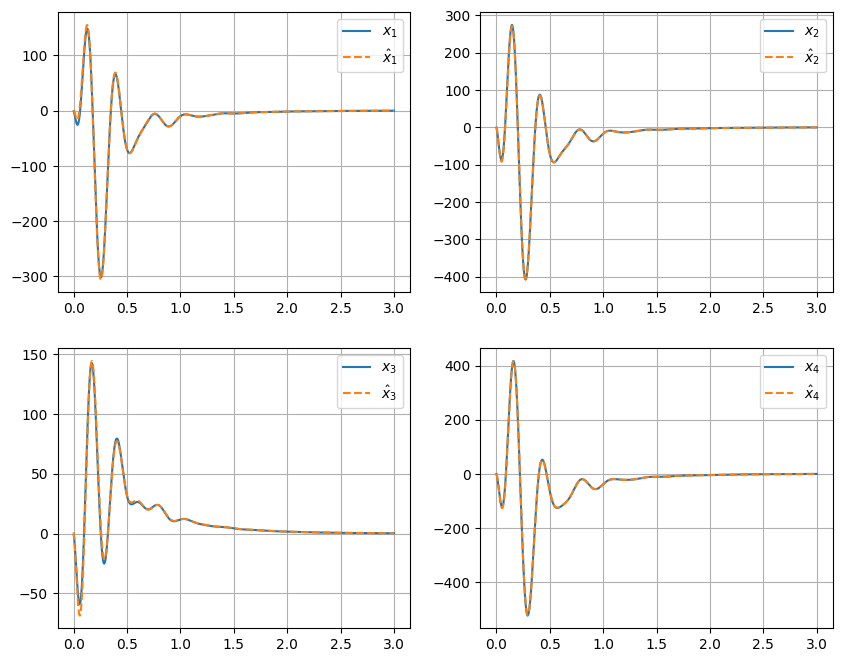

In [176]:
y = ys_4[1]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid()
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid()
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid()
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid()

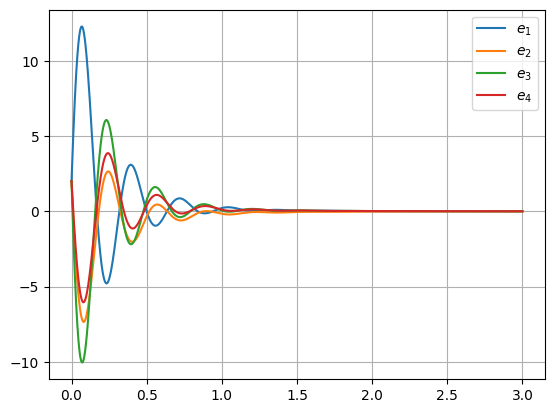

In [177]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.grid()

obs > cont

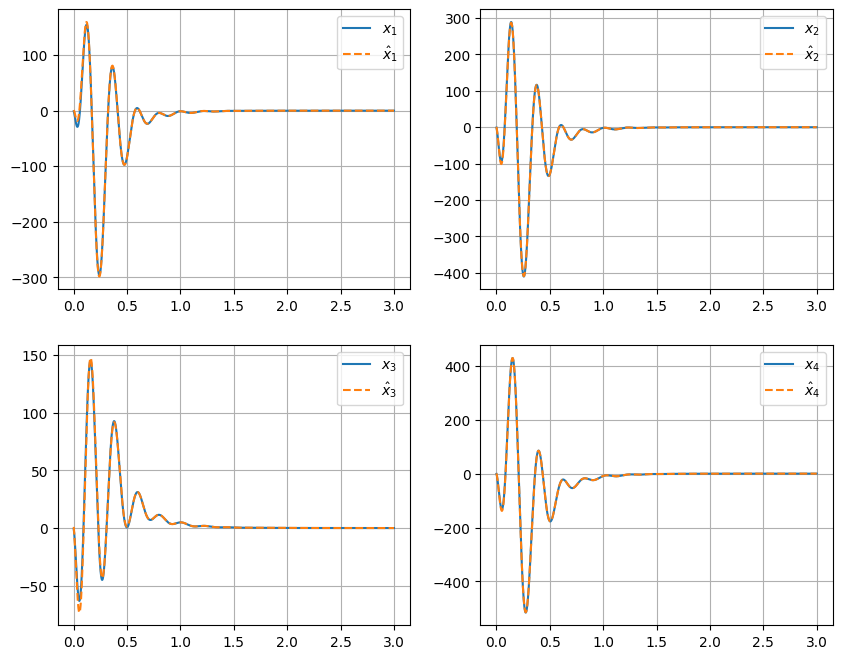

In [178]:
y = ys_4[2]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid()
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid()
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid()
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid()

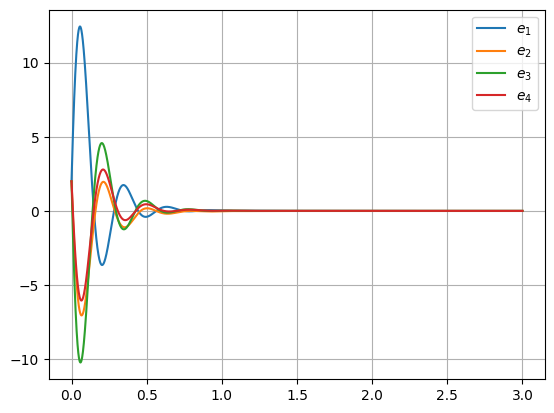

In [179]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.grid()